**基本介绍**

卷积网络的核心思想是将：局部感受野、权值共享以及时间或空间亚采样这三种结构思想结合起来获得了某种程度的位移、尺度、形变不变性.

卷积神经网络中的名词：

1、feature map

Feature Map(特征图)是输入图像经过神经网络卷积产生的结果。一张二值图就是一个feature map；一张RGB三色图就是3个feature map；

每一个feature-map都有宽度Width和高度Height。

2、channel

以图像为例，一张二值图只有1个channel；一张RGB图有3个channel；


3、卷积核

卷积核即特征提取器，每个卷积核有CHW，其中C与数据的Channel数相同；H和W是不定的。

卷积会改变高度、宽度以及通道数；通道数与卷积核的数量有关；卷积核的大小会影响到高度和宽度；

4、局部感受野

感受野（Receptive Field），指的是神经网络中神经元“看到的”输入区域，在卷积神经网络中，feature map上某个元素的计算受输入图像上某个区域的影响，这个区域即该元素的感受野。卷积神经网络中，越深层的神经元看到的输入区域越大。感受野指的是看到**输入图像上的区域**。

局部感受野就是输入图层中某一个H*W的区域。

参考：https://cloud.tencent.com/developer/article/1557374

5、权值共享

卷积核的权值在不同局部感受野上是共享的


**1、CNN与全连接网络的关联？**

在处理图像时，假设一张1000*1000的图，那么就有100w个像素值，若采用全连接网络，则会有1000*1000*100w个参数，无疑是巨大的。因而出现了CNN，这种局部感受野、权值共享的结构。CNN可以看作是权值共享的局部连接网络，如下图。

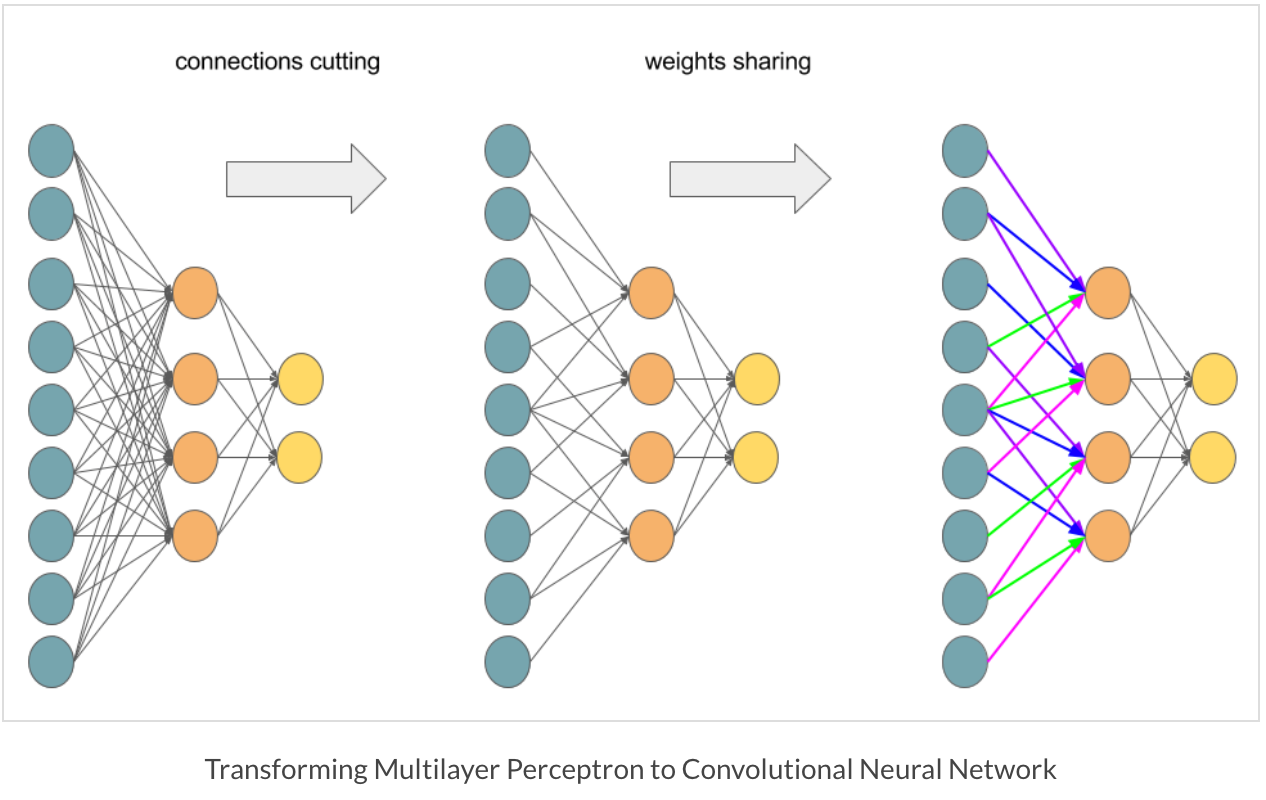

**2、CNN的相关计算？**


*a、正向计算*

卷积操作的参数包括卷积核大小（kernel size）、步长（stride）以及边缘填充（padding）三个参数。卷积后的feature map的尺寸为：
$$height_{out}=\lfloor \frac{height_{in} + 2*padding - kernel\_size}{stride} \rfloor + 1 \\
width_{out}=\lfloor \frac{width_{in} + 2*padding - kernei\_size}{stride} \rfloor + 1$$

其实，卷积核还有一个channel参数，但其数量与上一层的feature map保持一致，多channel的卷积核计算时，不同channel的卷积结果对应位置累加求和，得到最终的卷积结果。即最终得到的卷积结果是原始图像各个通道上的综合信息结果。

池化可以看成简化版的卷积，也是包括窗口width*height，以及stride的，包含max pooling、average pooling等。

总结如下：

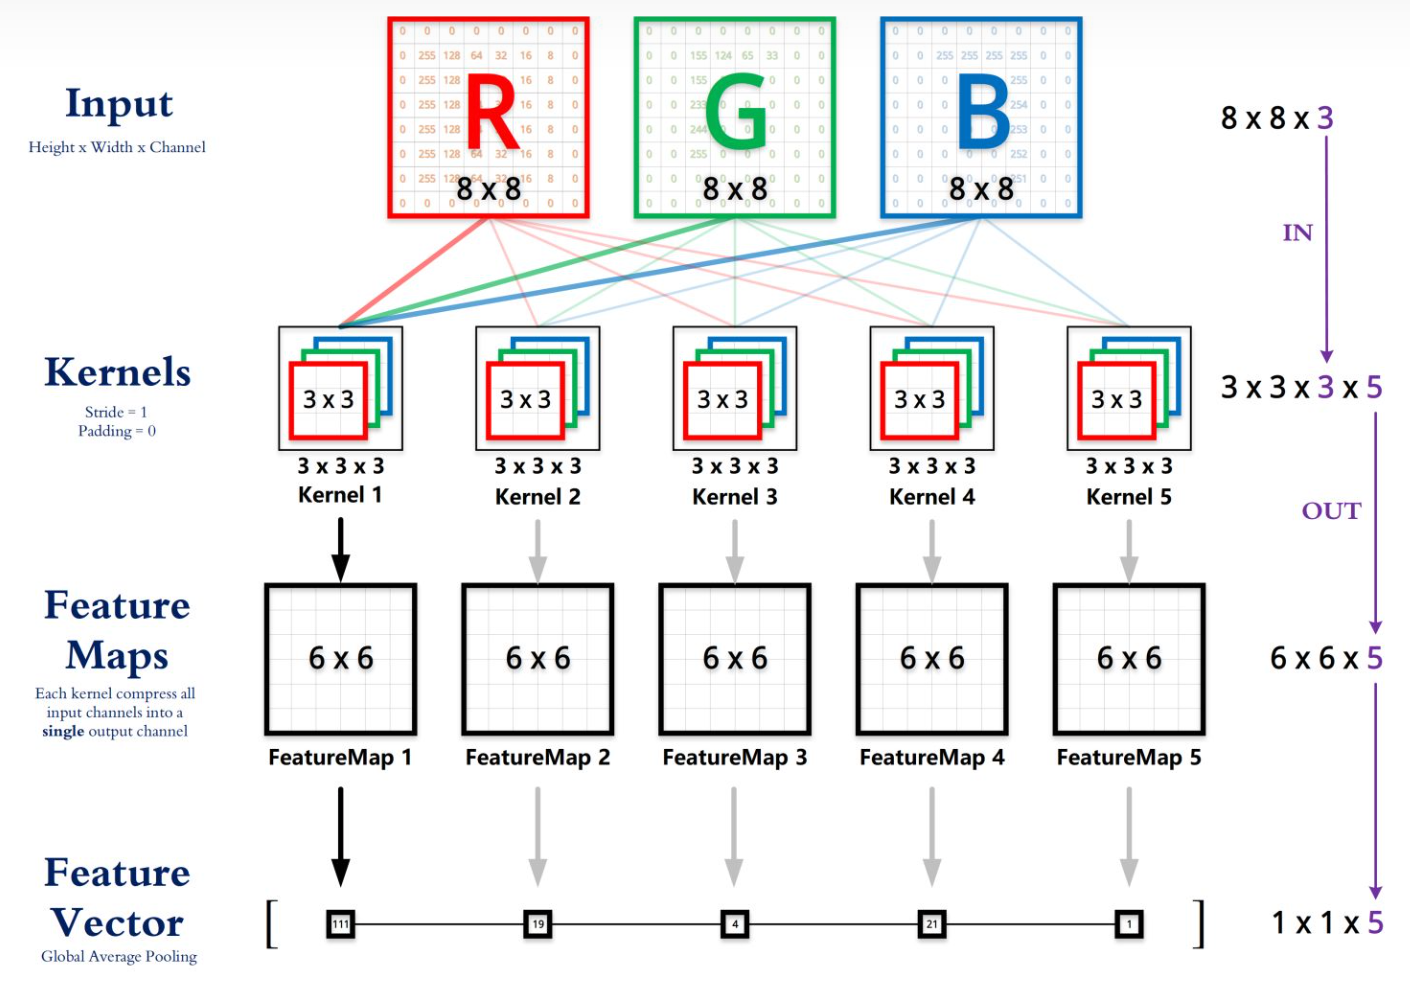


*b、反向传播*

池化层的反向传播需要看池化类型：max pooling反向传播时，只传播取最大值的区域。因此，不仅要记录区域的最大值，同时也要记录下来区域最大值的位置，方便delta误差的反向传播。average pooling区域中每个值对池化后结果贡献的权重都为区域大小的倒数，所以delta误差反向传播回来时，在区域每个位置的delta误差都为池化后delta误差除以区域的大小。

比如，一个4\*4的区域，经过2\*2，stride为1的池化后，尺寸为2\*2，反向传播时，假设$\delta_{l+1}$矩阵为
$\left[
 \begin{matrix}
   2 & 8  \\
   4 & 6 
  \end{matrix}
  \right]$
则第$l$层，使用最大池化和平均池化的结果分别为：
$$
\left[
 \begin{matrix}
   2 & 0 & 0 & 8  \\
   0 & 0 & 0 & 0  \\
   4 & 0 & 0 & 0  \\
   0 & 0 & 6 & 0
  \end{matrix}
  \right]
和  
\left[
 \begin{matrix}
   0.5 & 0.5 & 2 & 2  \\
   0.5 & 0.5 & 2 & 2  \\
   1 & 1 & 1.5 & 1.5 \\ 
   1 & 1 & 1.5 & 1.5
  \end{matrix}
  \right]
$$

----

卷积层的反向传播：原图的delta误差，等于卷积结果的delta误差经过零填充后，与卷积核旋转180度后的卷积。

具体来说：

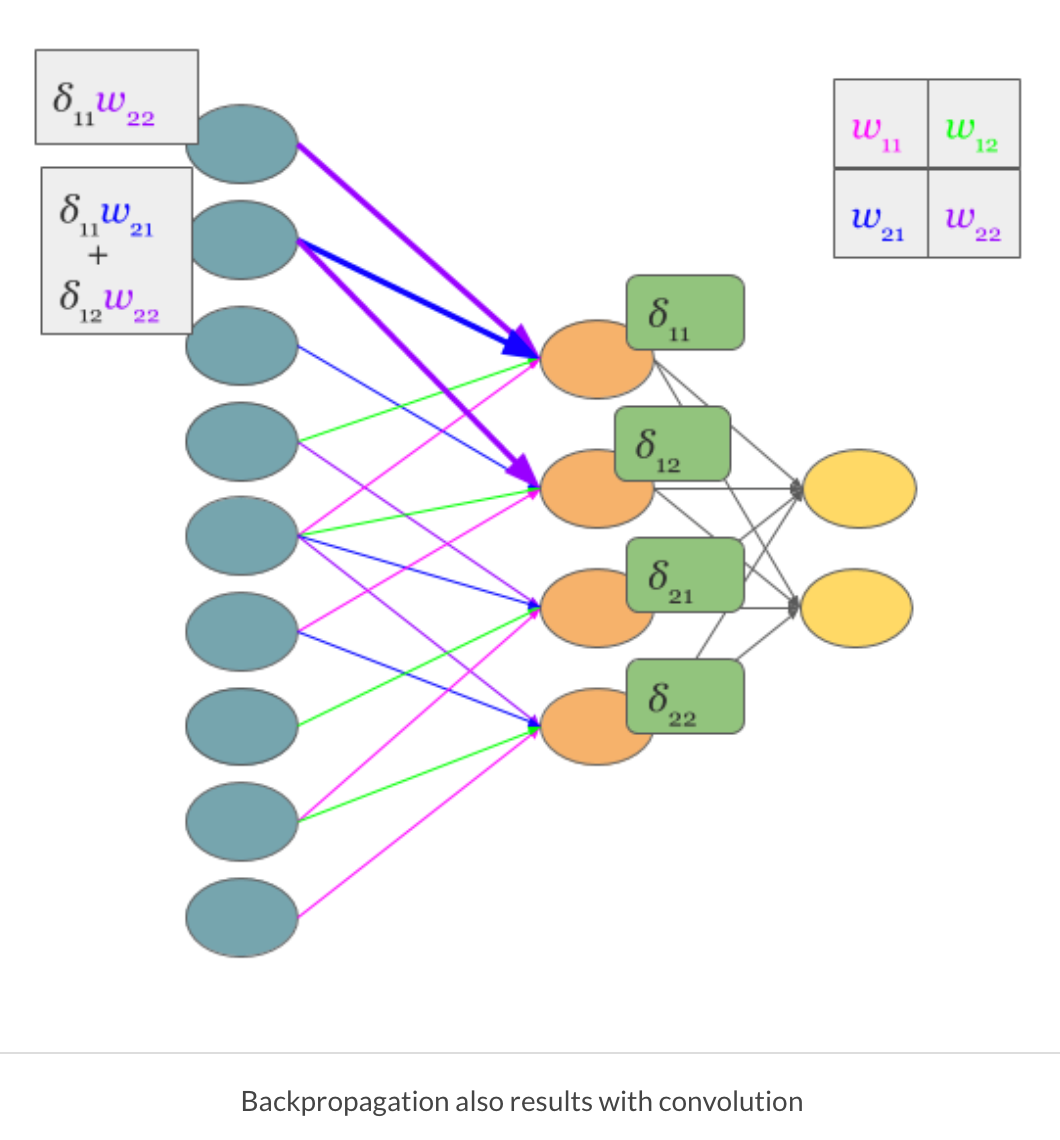

推导：

正向传播中，设$l+1$层的未激活输入（也即激活后的l层输出）为$z^{l+1}$，第$l$层激活的输出位$a^l$，卷积核权值为$\omega^{l+1}$，有如下关系：
$$z^{l+1} = a^l * \omega^{l+1}$$。

以3\*3输入经过2\*2卷积核做步长为1的valid卷积为例，
$$\left[
\begin{matrix}
z_{11} & z_{12} \\
z_{21} & z_{22}
\end{matrix}
\right]=
\left[
\begin{matrix}
a_{11} & a_{12} & a_{13} \\
a_{21} & a_{22} & a_{23}\\
a_{31} & a_{32} & a_{33}
\end{matrix}
\right]
*
\left[
\begin{matrix}
\omega_{11} & \omega_{12} \\
\omega_{21} & \omega_{22}
\end{matrix}
\right]
$$
可以得到如下关系：
$$
z_{11} = a_{11}\omega_{11} + a_{12}\omega_{12} + a_{21}\omega_{21} + a_{22}\omega_{22} \\
z_{12} = a_{12}\omega_{11} + a_{13}\omega_{22} + a_{22}\omega_{21} + a_{23}\omega_{22} \\ 
z_{21} = a_{21}\omega_{11} + a_{22}\omega_{12} + a_{31}\omega_{21} + a_{32}\omega_{22} \\ 
z_{22} = a_{22}\omega_{11} + a_{23}\omega_{12} + a_{32}\omega_{21} + a_{33}\omega_{22}
$$

又有如下关系：$z$矩阵对某个$a_{i,j}$求导的结果为$$\left[
\begin{matrix}
\frac{\partial z_{11}}{\partial a_{i,j}} & \frac{\partial z_{12}}{\partial a_{i,j}} \\
\frac{\partial z_{21}}{\partial a_{i,j}} & \frac{\partial z_{22}}{\partial a_{i,j}}
\end{matrix}
\right]$$

反向传播时，设在$l+1$层的误差为$C$，求导$l$层的梯度：
$$\frac{\partial C}{\partial a^l} = \frac{\partial C}{\partial z^{l+1}}\frac{\partial z^{l+1}}{\partial a^l}$$

令$$
\frac{\partial C}{\partial z^{l+1}} = \delta^{l+1} = \left[
\begin{matrix}
\delta_{11} & \delta_{12} \\
\delta_{21} & \delta_{22}
\end{matrix}
\right]
$$
所以，可以逐步求得误差对$a_{i,j}$的梯度为：
$$
\nabla a_{11} = \left[
\begin{matrix}
\delta_{11} & \delta_{12} \\
\delta_{21} & \delta_{22}
\end{matrix}
\right] \left[
\begin{matrix}
\frac{\partial z_{11}}{\partial a_{11}} & \frac{\partial z_{12}}{\partial a_{11}} \\
\frac{\partial z_{21}}{\partial a_{11}} & \frac{\partial z_{22}}{\partial a_{1}}
\end{matrix}
\right] = \left[
\begin{matrix}
\delta_{11} & \delta_{12} \\
\delta_{21} & \delta_{22}
\end{matrix}
\right] \left[
\begin{matrix}
\omega_{11} & 0 \\
0 & 0
\end{matrix}
\right] = \delta_{11}\omega_{11} 
$$
同理
$$\nabla a_{12}=\left[
\begin{matrix}
\delta_{11} & \delta_{12} \\
\delta_{21} & \delta_{22}
\end{matrix}
\right] \left[
\begin{matrix}
\omega_{12} & \omega_{11} \\
0 & 0
\end{matrix}
\right] = \delta_{11}\omega_{12} + \delta_{12}\omega_{11} \\
...
\nabla a_{33}=\left[
\begin{matrix}
\delta_{11} & \delta_{12} \\
\delta_{21} & \delta_{22}
\end{matrix}
\right] \left[
\begin{matrix}
0 & 0 \\
0 & \omega_{22}
\end{matrix}
\right] = \delta_{22}\omega_{22}$$

整理可以得到：

$$
\left[
\begin{matrix}
\nabla a_{11} & \nabla a_{12} & \nabla a_{13}\\
\nabla a_{21} & \nabla a_{22} & \nabla a_{23}\\
\nabla a_{31} & \nabla a_{32} & \nabla a_{33}
\end{matrix}
\right] = \left[
\begin{matrix}
0 & 0 & 0 & 0 \\
0 & \delta_{11} & \delta_{12} & 0\\
0 & \delta_{21} & \delta_{22} & 0 \\ 
0 & 0 & 0 & 0 \\
\end{matrix}
\right] * \left[
\begin{matrix}
\omega_{22} & \omega_{21} \\
\omega_{12} & \omega_{11}
\end{matrix}
\right]
$$

最终，第$l$层的误差可以表示为：

$$\delta^l = (\delta^{l+1} * rotate180(\omega^{l+1}))\odot(\sigma'(z^l))$$

参考：https://blog.csdn.net/qq_16137569/article/details/81477906 & https://grzegorzgwardys.wordpress.com/2016/04/22/8/

In [37]:
# 3、CNN卷积实现

import numpy as np
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class Conv3x3:
    def __init__(self, num_filters):
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, 3, 3) / 9
    
    def iterate_regions(self, image):
        '''
        param image: h*w的二维feature
        '''
        h, w = image.shape
        
        for i in range(h-2):
            for j in range(w-2):
                im_region = image[i:(i+3), j:(j+3)]
                yield im_region, i, j
    
    def forward(self, inputs):
        '''
        param inputs: h*w的二维feature
        '''
        self.last_input = inputs
        (h, w) = inputs.shape
        output = np.zeros((h - 2, w - 2, self.num_filters))
        for im_region, i, j in self.iterate_regions(inputs):
            output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))
        
        return output
    
    def backprop(self, d_L_d_out, learn_rate):
        '''
        param d_L_d_out: 图像对应的误差梯度，shape：i*j*f，对应上一层的图像区域i,j以及卷积核个数
        param learn_rate: 学习率
        '''
        d_L_d_filters = np.zeros(self.filters.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region
        
        self.filters -= learn_rate * d_L_d_filters

class MaxPooling:
    def __init__(self):
        pass
    
    def iterate_regions(self, image):
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2
        
        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j
    
    def forward(self, image):
        self.last_input = image

        # input: 3d matrix of conv layer
        h, w, num_filters = image.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(image):
            output[i, j] = np.amax(im_region, axis=(0, 1))
        
        return output
    
    def backprop(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)
        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0, 1))
            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        # If this pixel was the max value, copy the gradient to it.
                        if im_region[i2, j2, f2] == amax[f2]:
                            d_L_d_input[i + i2, j + j2, f2] = d_L_d_out[i, j, f2]
        return d_L_d_input

class Softmax:
    def __init__(self, input_len, nodes):
        self.weights = np.random.randn(input_len, nodes) / input_len
        self.biases = np.zeros(nodes)
    
    def forward(self, inputs):
        self.last_input_shape = inputs.shape
        inputs = inputs.flatten()
        self.last_input = inputs
        
        input_len, nodes = self.weights.shape
        
        totals = np.dot(inputs, self.weights) + self.biases
        self.last_totals = totals
        exp = np.exp(totals)
        return exp / np.sum(exp, axis=0)
    
    def backprop(self, d_L_d_out, learn_rate):
        for i, gradient in enumerate(d_L_d_out):
            if gradient == 0:
                continue
            t_exp = np.exp(self.last_totals)
            S = np.sum(t_exp)
            d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
            d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)
            
            d_t_d_w = self.last_input  # vector
            d_t_d_b = 1
            d_t_d_inputs = self.weights
            d_L_d_t = gradient * d_out_d_t
            d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
            d_L_d_b = d_L_d_t * d_t_d_b
            d_L_d_inputs = d_t_d_inputs @ d_L_d_t
            self.weights -= learn_rate * d_L_d_w
            self.biases -= learn_rate * d_L_d_b
            return d_L_d_inputs.reshape(self.last_input_shape)
train_images = x_train[:1000]
train_labels = y_train[:1000]
test_images = x_test[:1000]
test_labels = y_test[:1000]
conv = Conv3x3(8)                    # 28x28x1 -> 26x26x8
pool = MaxPooling()                    # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10)    # 13x13x8 -> 10

def forward(image, label):
    '''
    Completes a forward pass of the CNN and calculates the accuracy and
    cross-entropy loss.
    - image is a 2d numpy array
    - label is a digit
    '''
    # We transform the image from [0, 255] to [-0.5, 0.5] to make it easier
    # to work with. This is standard practice.
    out = conv.forward((image / 255) - 0.5)
    out = pool.forward(out)
    out = softmax.forward(out)

    # Calculate cross-entropy loss and accuracy. np.log() is the natural log.
    loss = -np.log(out[label])
    acc = 1 if np.argmax(out) == label else 0

    return out, loss, acc

def train(im, label, lr=.005):
    # Forward
    out, loss, acc = forward(im, label)
    
    # Calculate intial gradient
    gradient = np.zeros(10)
    gradient[label] = -1 / out[label]
    
    # Backprop
    gradient = softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)
    
    return loss, acc


for epoch in range(3):
    print('--- Epoch %d ---' % (epoch + 1))
    
    # Shuffle the training data
    permutation = np.random.permutation(len(train_images))
    train_images = train_images[permutation]
    train_labels = train_labels[permutation]
    
    # Train
    loss = 0
    num_correct = 0
    # i: index
    # im: image
    # label: label
    for i, (im, label) in enumerate(zip(train_images, train_labels)):
        if i > 0 and i % 100 == 99:
            print(
                '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
                (i + 1, loss / 100, num_correct)
            )
            loss = 0
            num_correct = 0

        l, acc = train(im, label)
        loss += 1
        num_correct += acc
        
# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
    _, l, acc = forward(im, label)
    loss += l
    num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 0.990 | Accuracy: 20%
[Step 200] Past 100 steps: Average Loss 1.000 | Accuracy: 38%
[Step 300] Past 100 steps: Average Loss 1.000 | Accuracy: 47%
[Step 400] Past 100 steps: Average Loss 1.000 | Accuracy: 53%
[Step 500] Past 100 steps: Average Loss 1.000 | Accuracy: 59%
[Step 600] Past 100 steps: Average Loss 1.000 | Accuracy: 70%
[Step 700] Past 100 steps: Average Loss 1.000 | Accuracy: 72%
[Step 800] Past 100 steps: Average Loss 1.000 | Accuracy: 75%
[Step 900] Past 100 steps: Average Loss 1.000 | Accuracy: 74%
[Step 1000] Past 100 steps: Average Loss 1.000 | Accuracy: 77%
--- Epoch 2 ---
[Step 100] Past 100 steps: Average Loss 0.990 | Accuracy: 71%
[Step 200] Past 100 steps: Average Loss 1.000 | Accuracy: 80%
[Step 300] Past 100 steps: Average Loss 1.000 | Accuracy: 83%
[Step 400] Past 100 steps: Average Loss 1.000 | Accuracy: 88%
[Step 500] Past 100 steps: Average Loss 1.000 | Accuracy: 78%
[Step 600] Past 100 steps: Average Lo

**4、卷积计算的优化？**

A、caffe中提到的img2col

img2col操作把kernel变成列向量，把kernel对应的局部数据（receptive field）变成行向量。

具体来讲如下图：
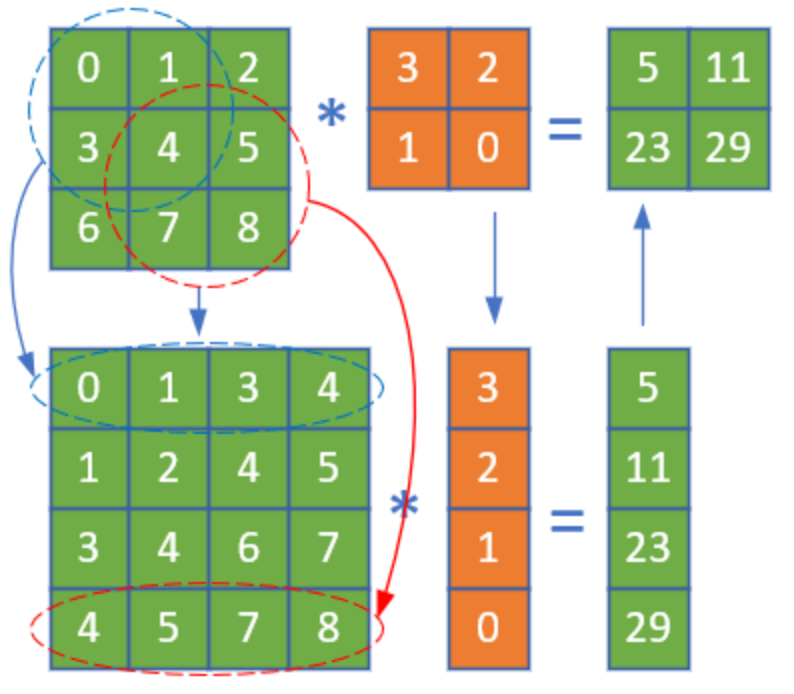

卷积操作是原始图片数据与卷积核逐点相乘的结果，所以遍历每个点的运算速度非常慢。在全连接层中，由于是两个矩阵直接相乘，所以速度非常快。如上所示把逐点相乘变成矩阵相乘。

*为什么要将卷积操作转化为 GEMM（通用矩阵乘，General Matrix Multiply） 呢？*

*1、因为线性代数领域已经有非常成熟的计算接口（BLAS，Fortran 语言实现）来高效地实现大型的矩阵乘法，几乎可以做到极限优化。*

*2、将卷积过程中用到的所有特征子矩阵整合成一个大型矩阵存放在连续的内存中，虽然增加了存储成本，但是减少了内存访问的次数，从而缩短了计算时间。*

*将所有特征子矩阵都堆叠到一个矩阵中，会不会导致内存不够用或者计算速度非常慢？*

*不用担心，因为矩阵的存储和计算其实都是非常规则的，很容易通过分布式和并行的方式来解决。*

**在前向计算中，使用img2col进行转换，在反向传播时，需要col2img，其思想是：把反向传播也看作是全连接层的方式，直接用矩阵运算代替卷积操作，然后把结果矩阵再转换成卷积操作的反向传播所需要的形状。**

参考：https://juejin.cn/post/7068113084451127333

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

def relu(input_X):
	"""
	Arguments:
		input_X -- a numpy array
	Return :
		A: a numpy array. let each elements in array all greater or equal 0
	"""
	
	A = np.where(input_X < 0, 0, input_X)
	return A


def softmax(input_X):
    """
    Arguments:
        input_X -- a numpy array
    Return :
        A: a numpy array same shape with input_X
    """
    exp_a = np.exp(input_X)
    sum_exp_a = np.sum(exp_a,axis=1)
    sum_exp_a = sum_exp_a.reshape(input_X.shape[0],-1)
    ret = exp_a/sum_exp_a
    # print(ret)
    return ret


def cross_entropy_error(labels, logits):
	"""
	交叉熵误差函数
	:param labels:
	:param logits:
	:return:
	"""
	return -np.sum(labels * np.log(logits))


def im2col2(input_data, fh, fw, stride=1, pad=0):
	'''
	 Arguments:
	 input_data--输入数据，shape为(Number of example,Channel,Height,Width)
	 fh -- 滤波器的height
	 fw --滤波器的width
	 stride -- 步幅
	 pad -- 填充

	 Returns :
	 col -- 输入数据根据滤波器、步幅等展开的二维数组，每一行代表一条卷积数据
	'''
	N, C, H, W = input_data.shape
	
	out_h = (H + 2 * pad - fh) // stride + 1
	out_w = (W + 2 * pad - fw) // stride + 1
	
	img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], "constant")
	
	col = np.zeros((N, out_h, out_w, fh * fw * C))
	
	# 将所有维度上需要卷积的值展开成一列
	for y in range(out_h):
		y_start = y * stride
		y_end = y_start + fh
		for x in range(out_w):
			x_start = x * stride
			x_end = x_start + fw
			col[:, y, x] = img[:, :, y_start:y_end, x_start:x_end].reshape(N, -1)
	col = col.reshape(N * out_h * out_w, -1)
	return col


def col2im2(col, out_shape, fh, fw, stride=1, pad=0):
	'''
	 Arguments:
	 col: 二维数组
	 out_shape-- 输出的shape，shape为(Number of example,Channel,Height,Width)
	 fh -- 滤波器的height
	 fw --滤波器的width
	 stride -- 步幅
	 pad -- 填充

	 Returns :
	 img -- 将col转换成的img ，shape为out_shape
	'''
	N, C, H, W = out_shape
	
	col_m, col_n = col.shape
	
	out_h = (H + 2 * pad - fh) // stride + 1
	out_w = (W + 2 * pad - fw) // stride + 1
	
	img = np.zeros((N, C, H, W))
	# img = np.pad(img,[(0,0),(0,0),(pad,pad),(pad,pad)],"constant")
	
	# 将col转换成一个filter
	for c in range(C):
		for y in range(out_h):
			for x in range(out_w):
				col_index = (c * out_h * out_w) + y * out_w + x
				ih = y * stride
				iw = x * stride
				img[:, c, ih:ih + fh, iw:iw + fw] = col[col_index].reshape((fh, fw))
	return img


def compute_cost(logits,label):
    return cross_entropy_error(label,logits)


In [56]:

class Convolution:
	def __init__(self, W, fb, stride=1, pad=0):
		"""
		W-- 滤波器权重，shape为(FN,NC,FH,FW),FN 为滤波器的个数
		fb -- 滤波器的偏置，shape 为(1,FN)
		stride -- 步长
		pad -- 填充个数
		"""
		self.W = W
		self.fb = fb
		self.stride = stride
		self.pad = pad
		
		self.col_X = None
		self.X = None
		self.col_W = None
		
		self.dW = None
		self.db = None
		self.out_shape = None
	
	#    self.out = None
	
	def forward(self, input_X):
		"""
		input_X-- shape为(m,nc,height,width)
		"""
		self.X = input_X
		FN, NC, FH, FW = self.W.shape
		
		m, input_nc, input_h, input_w = self.X.shape
		
		# 先计算输出的height和widt
		out_h = int((input_h + 2 * self.pad - FH) / self.stride + 1)
		out_w = int((input_w + 2 * self.pad - FW) / self.stride + 1)
		
		# 将输入数据展开成二维数组，shape为（m*out_h*out_w,FH*FW*C)
		self.col_X = col_X = im2col2(self.X, FH, FW, self.stride, self.pad)
		
		# 将滤波器一个个按列展开(FH*FW*C,FN)
		self.col_W = col_W = self.W.reshape(FN, -1).T
		out = np.dot(col_X, col_W) + self.fb
		out = out.T
		out = out.reshape(m, FN, out_h, out_w)
		self.out_shape = out.shape
		return out
	
	def backward(self, dz, learning_rate):
		# print("==== Conv backbward ==== ")
		assert (dz.shape == self.out_shape)
		
		FN, NC, FH, FW = self.W.shape
		o_FN, o_NC, o_FH, o_FW = self.out_shape
		
		col_dz = dz.reshape(o_NC, -1)
		col_dz = col_dz.T
		
		self.dW = np.dot(self.col_X.T, col_dz)  # shape is (FH*FW*C,FN)
		self.db = np.sum(col_dz, axis=0, keepdims=True)
		
		self.dW = self.dW.T.reshape(self.W.shape)
		self.db = self.db.reshape(self.fb.shape)
		
		d_col_x = np.dot(col_dz, self.col_W.T)  # shape is (m*out_h*out_w,FH,FW*C)
		dx = col2im2(d_col_x, self.X.shape, FH, FW, stride=1)
		
		assert (dx.shape == self.X.shape)
		
		# 更新W和b
		self.W = self.W - learning_rate * self.dW
		self.fb = self.fb - learning_rate * self.db
		
		return dx


class Pooling:
	def __init__(self, pool_h, pool_w, stride=1, pad=0):
		self.pool_h = pool_h
		self.pool_w = pool_w
		self.stride = stride
		self.pad = pad
		self.X = None
		self.arg_max = None
	
	def forward(self, input_X):
		"""
		前向传播
		input_X-- shape为(m,nc,height,width)
		"""
		self.X = input_X
		N, C, H, W = input_X.shape
		out_h = int(1 + (H - self.pool_h) / self.stride)
		out_w = int(1 + (W - self.pool_w) / self.stride)
		
		# 展开
		col = im2col2(input_X, self.pool_h, self.pool_w, self.stride, self.pad)
		col = col.reshape(-1, self.pool_h * self.pool_w)
		arg_max = np.argmax(col, axis=1)
		# 最大值
		out = np.max(col, axis=1)
		out = out.T.reshape(N, C, out_h, out_w)
		self.arg_max = arg_max
		return out
	
	def backward(self, dz):
		"""
		反向传播
		Arguments:
		dz-- out的导数，shape与out 一致

		Return:
		返回前向传播是的input_X的导数
		"""
		pool_size = self.pool_h * self.pool_w
		dmax = np.zeros((dz.size, pool_size))
		dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dz.flatten()
		
		dx = col2im2(dmax, out_shape=self.X.shape, fh=self.pool_h, fw=self.pool_w, stride=self.stride)
		return dx


class Relu:
	def __init__(self):
		self.mask = None
	
	def forward(self, X):
		self.mask = X <= 0
		out = X
		out[self.mask] = 0
		return out
	
	def backward(self, dz):
		dz[self.mask] = 0
		dx = dz
		return dx


class SoftMax:
	def __init__(self):
		self.y_hat = None
	
	def forward(self, X):
		self.y_hat = softmax(X)
		return self.y_hat
	
	def backward(self, labels):
		m = labels.shape[0]
		dx = (self.y_hat - labels)
		
		return dx


class Affine:
	def __init__(self, W, b):
		self.W = W  # shape is (n_x,n_unit)
		self.b = b  # shape is(1,n_unit)
		self.X = None
		self.origin_x_shape = None
		
		self.dW = None
		self.db = None
		
		self.out_shape = None
	
	def forward(self, X):
		self.origin_x_shape = X.shape
		self.X = X.reshape(X.shape[0], -1)  # (m,n)
		out = np.dot(self.X, self.W) + self.b
		self.out_shape = out.shape
		return out
	
	def backward(self, dz, learning_rate):
		"""
		dz-- 前面的导数
		"""
		#         print("Affine backward")
		#         print(self.X.shape)
		#         print(dz.shape)
		#         print(self.W.shape)
		
		assert (dz.shape == self.out_shape)
		
		m = self.X.shape[0]
		
		self.dW = np.dot(self.X.T, dz) / m
		self.db = np.sum(dz, axis=0, keepdims=True) / m
		
		assert (self.dW.shape == self.W.shape)
		assert (self.db.shape == self.b.shape)
		
		dx = np.dot(dz, self.W.T)
		assert (dx.shape == self.X.shape)
		
		dx = dx.reshape(self.origin_x_shape)  # 保持与之前的x一样的shape
		
		# 更新W和b
		self.W = self.W - learning_rate * self.dW
		self.b = self.b - learning_rate * self.db
		
		return dx


In [57]:
class SimpleConvNet:
	
	def __init__(self):
		self.X = None
		self.Y = None
		self.layers = []
	
	def add_conv_layer(self, n_filter, n_c, f, stride=1, pad=0):
		"""
		添加一层卷积层
		Arguments:
		n_c -- 输入数据通道数，也即卷积层的通道数
		n_filter -- 滤波器的个数
		f --滤波器的长/宽

		Return :
		Conv -- 卷积层
		"""
		
		# 初始化W，b
		W = np.random.randn(n_filter, n_c, f, f) * 0.01
		fb = np.zeros((1, n_filter))
		# 卷积层
		Conv = Convolution(W, fb, stride=stride, pad=pad)
		return Conv
	
	def add_maxpool_layer(self, pool_shape, stride=1, pad=0):
		"""
		添加一层池化层
		Arguments:
		pool_shape -- 滤波器的shape
		f -- 滤波器大小
		Return :
		 Pool -- 初始化的Pool类
		"""
		pool_h, pool_w = pool_shape
		pool = Pooling(pool_h, pool_w, stride=stride, pad=pad)
		
		return pool
	
	def add_affine(self, n_x, n_units):
		"""
		添加一层全连接层
		Arguments:
		n_x -- 输入个数
		n_units -- 神经元个数
		Return :
		fc_layer -- Affine层对象
		"""
		
		W = np.random.randn(n_x, n_units) * 0.01
		
		b = np.zeros((1, n_units))
		
		fc_layer = Affine(W, b)
		
		return fc_layer
	
	def add_relu(self):
		relu_layer = Relu()
		return relu_layer
	
	def add_softmax(self):
		softmax_layer = SoftMax()
		return softmax_layer
	
	# 计算卷积或池化后的H和W
	def cacl_out_hw(self, HW, f, stride=1, pad=0):
		return (HW + 2 * pad - f) / stride + 1
	
	def init_model(self, train_X, n_classes):
		"""
		初始化一个卷积层网络
		"""
		N, C, H, W = train_X.shape
		# 卷积层
		n_filter = 4
		f = 7
		
		conv_layer = self.add_conv_layer(n_filter=n_filter, n_c=C, f=f, stride=1)
		
		out_h = self.cacl_out_hw(H, f)
		out_w = self.cacl_out_hw(W, f)
		out_ch = n_filter
		
		self.layers.append(conv_layer)
		
		# Relu
		relu_layer = self.add_relu()
		self.layers.append(relu_layer)
		
		# 池化
		f = 2
		pool_layer = self.add_maxpool_layer(pool_shape=(f, f), stride=2)
		out_h = self.cacl_out_hw(out_h, f, stride=2)
		out_w = self.cacl_out_hw(out_w, f, stride=2)
		# out_ch 不改变
		self.layers.append(pool_layer)
		
		# Affine层
		n_x = int(out_h * out_w * out_ch)
		n_units = 32
		fc_layer = self.add_affine(n_x=n_x, n_units=n_units)
		self.layers.append(fc_layer)
		
		# Relu
		relu_layer = self.add_relu()
		self.layers.append(relu_layer)
		
		# Affine
		fc_layer = self.add_affine(n_x=n_units, n_units=n_classes)
		self.layers.append(fc_layer)
		
		# SoftMax
		softmax_layer = self.add_softmax()
		self.layers.append(softmax_layer)
	
	def forward_progation(self, train_X, print_out=False):
		"""
		前向传播
		Arguments:
		train_X -- 训练数据
		f -- 滤波器大小

		Return :
		 Z-- 前向传播的结果
		 loss -- 损失值
		"""
		
		N, C, H, W = train_X.shape
		index = 0
		# 卷积层
		conv_layer = self.layers[index]
		X = conv_layer.forward(train_X)
		index = index + 1
		if print_out:
			print("卷积之后：" + str(X.shape))
		# Relu
		relu_layer = self.layers[index]
		index = index + 1
		X = relu_layer.forward(X)
		if print_out:
			print("Relu：" + str(X.shape))
		
		# 池化层
		pool_layer = self.layers[index]
		index = index + 1
		X = pool_layer.forward(X)
		if print_out:
			print("池化：" + str(X.shape))
		
		# Affine层
		fc_layer = self.layers[index]
		index = index + 1
		X = fc_layer.forward(X)
		if print_out:
			print("Affline 层的X：" + str(X.shape))
		
		# Relu
		relu_layer = self.layers[index]
		index = index + 1
		X = relu_layer.forward(X)
		if print_out:
			print("Relu 层的X：" + str(X.shape))
		
		# Affine层
		fc_layer = self.layers[index]
		index = index + 1
		X = fc_layer.forward(X)
		if print_out:
			print("Affline 层的X：" + str(X.shape))
		
		# SoftMax层
		sofmax_layer = self.layers[index]
		index = index + 1
		A = sofmax_layer.forward(X)
		if print_out:
			print("Softmax 层的X：" + str(A.shape))
		
		return A
	
	def back_progation(self, train_y, learning_rate):
		"""
		反向传播
		Arguments:

		"""
		index = len(self.layers) - 1
		sofmax_layer = self.layers[index]
		index -= 1
		dz = sofmax_layer.backward(train_y)
		
		fc_layer = self.layers[index]
		dz = fc_layer.backward(dz, learning_rate=learning_rate)
		index -= 1
		
		relu_layer = self.layers[index]
		dz = relu_layer.backward(dz)
		index -= 1
		
		fc_layer = self.layers[index]
		dz = fc_layer.backward(dz, learning_rate=learning_rate)
		index -= 1
		
		pool_layer = self.layers[index]
		dz = pool_layer.backward(dz)
		index -= 1
		
		relu_layer = self.layers[index]
		dz = relu_layer.backward(dz)
		index -= 1
		
		conv_layer = self.layers[index]
		conv_layer.backward(dz, learning_rate=learning_rate)
		index -= 1
	
	def get_minibatch(self, batch_data, minibatch_size, num):
		m_examples = batch_data.shape[0]
		minibatches = math.ceil(m_examples / minibatch_size)
		
		if (num < minibatches):
			return batch_data[num * minibatch_size:(num + 1) * minibatch_size]
		else:
			return batch_data[num * minibatch_size:m_examples]
	
	def optimize(self, train_X, train_y, minibatch_size, learning_rate=0.05, num_iters=500):
		"""
		优化方法
		Arguments:
		train_X -- 训练数据
		train_y -- 训练数据的标签
		learning_rate -- 学习率
		num_iters -- 迭代次数
		minibatch_size
		"""
		m = train_X.shape[0]
		num_batches = math.ceil(m / minibatch_size)
		
		costs = []
		for iteration in range(num_iters):
			iter_cost = 0
			for batch_num in range(num_batches):
				minibatch_X = self.get_minibatch(train_X, minibatch_size, batch_num)
				minibatch_y = self.get_minibatch(train_y, minibatch_size, batch_num)
				
				# 前向传播
				A = self.forward_progation(minibatch_X, print_out=False)
				# 损失:
				cost = compute_cost(A, minibatch_y)
				# 反向传播
				self.back_progation(minibatch_y, learning_rate)
				if (iteration % 100 == 0):
					iter_cost += cost / num_batches
			
			if (iteration % 100 == 0):
				print("After %d iters ,cost is :%g" % (iteration, iter_cost))
				costs.append(iter_cost)
		
		# 画出损失函数图
		plt.plot(costs)
		plt.xlabel("iterations/hundreds")
		plt.ylabel("costs")
		plt.show()
	
	def predicate(self, train_X):
		"""
		预测
		"""
		logits = self.forward_progation(train_X)
		one_hot = np.zeros_like(logits)
		one_hot[range(train_X.shape[0]), np.argmax(logits, axis=1)] = 1
		return one_hot
	
	def fit(self, train_X, train_y):
		"""
		训练
		"""
		self.X = train_X
		self.Y = train_y
		n_y = train_y.shape[1]
		m = train_X.shape[0]
		
		# 初始化模型
		self.init_model(train_X, n_classes=n_y)
		
		self.optimize(train_X, train_y, minibatch_size=10, learning_rate=0.05, num_iters=800)
		
		logits = self.predicate(train_X)
		
		accuracy = np.sum(np.argmax(logits, axis=1) == np.argmax(train_y, axis=1)) / m
		print("训练集的准确率为：%g" % (accuracy))

shape of x_train is :(60000, 1, 28, 28)
shape of t_train is :(60000, 10)
shape of x_test is :(10000, 1, 28, 28)
shape of t_test is :(10000, 10)
After 0 iters ,cost is :23.0278
After 100 iters ,cost is :22.6414
After 200 iters ,cost is :22.6361
After 300 iters ,cost is :22.605
After 400 iters ,cost is :22.3861
After 500 iters ,cost is :19.8486
After 600 iters ,cost is :4.56492
After 700 iters ,cost is :4.4185


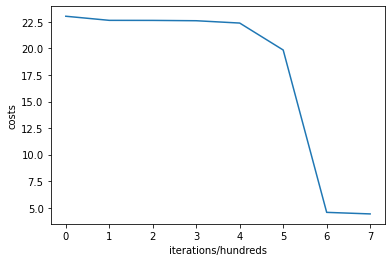

训练集的准确率为：0.12


In [63]:
from tensorflow.keras.datasets import mnist

def one_hot_label(y):
	one_hot_label = np.zeros((y.shape[0], 10))
	y = y.reshape(y.shape[0])
	one_hot_label[range(y.shape[0]), y] = 1
	return one_hot_label


(x_train_origin, t_train_origin), (x_test_origin, t_test_origin) = mnist.load_data()
X_train = x_train_origin/255.0
X_test = x_test_origin/255.0
m,h,w = x_train_origin.shape
X_train = X_train.reshape((m,1,h,w))
y_train = one_hot_label(t_train_origin)

m,h,w = x_test_origin.shape
X_test = X_test.reshape((m,1,h,w))
y_test = one_hot_label(t_test_origin)
print("shape of x_train is :"+repr(X_train.shape))
print("shape of t_train is :"+repr(y_train.shape))
print("shape of x_test is :"+repr(X_test.shape))
print("shape of t_test is :"+repr(y_test.shape))


convNet = SimpleConvNet()
#拿20张先做实验
train_X = X_train[0:100]
train_y = y_train[0:100]
convNet.fit(train_X,train_y)

**4、经典的CNN模型？**

参考：https://www.cnblogs.com/skyfsm/p/8451834.html、

https://cloud.tencent.com/developer/article/1038802

**5、1\*1卷积核的用处？**